In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from exp_analysis import *

In [21]:
from Likelihood import LEff
import emcee
import corner
from multiprocessing import Pool

In [22]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [23]:
n_evt = 1000000
m4_limits = (0.005, 1)
mz_limits = (0.005, 3)
hierarchy = 'heavy'
df_base = pd.read_pickle(f'../data/nd280_nu/3plus1/scan/heavy_mediator/{m4_limits[0]}_m4_{m4_limits[1]}_{mz_limits[0]}_mzprime_{mz_limits[1]}_nevt_{n_evt}.pckl')
initialise_df(df_base, is_scan='m4_mz')

In [57]:
hierarchy = 'heavy'

In [24]:
!mkdir -p ../fig/mcmc_minimal_heavy/
save_folder = "../fig/mcmc_minimal_heavy/"

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [25]:
observed_events = 0

span_2d = (m4_limits[1] - m4_limits[0]) * (mz_limits[1] - mz_limits[0])
# need to verify if this span 2d is correct or not

m4_values = df_base['m4', ''].values
mz_values = df_base['mzprime', ''].values

smooth_m4 = 0.05
smooth_mz = 0.015

selection_step = 'cut_based'
actual_weights = df_base['actual_weight', ''].values * df_base[selection_step, ''].values

int_x, int_y, int_z = df_base['int_point', 'x'].values, df_base['int_point', 'y'].values, df_base['int_point', 'z'].values
length_x, length_y, length_z = df_base['unitary_decay_length', 'x'].values, df_base['unitary_decay_length', 'y'].values, df_base['unitary_decay_length', 'z'].values

alpha_dark = 0.4
Umu4 = 2.2e-7
espilon2 = 4.6e-4
alpha_em = 1/137.
Vmu4_alpha_epsilon2 = alpha_dark * Umu4 * alpha_em * espilon2

In [26]:
def heavy_minimal_posterior(parameters, observed_events, m4_values, m4_limits, mz_values, mz_limits, span_2d, smooth_m4, smooth_mz, actual_weights, Vmu4_alpha_epsilon2, int_x, int_y, int_z, length_x, length_y, length_z):
    '''Posterior in the minimal model: parameters = [m4, mz, mu_Vmu4_alpha_epsilon2]'''
    if (parameters[0] < m4_limits[0]) or\
       (parameters[0] > m4_limits[1]) or\
       (parameters[1] < mz_limits[0]) or\
       (parameters[1] > mz_limits[1] or\
       (parameters[0] >= parameters[1])) or\
       (parameters[2] <= 0):
        return -np.inf
    else:
        actual_Vmu4_alpha_epsilon2 = Vmu4_alpha_epsilon2 * parameters[2]
        ctau = ctau_heavy(parameters[0], parameters[1], actual_Vmu4_alpha_epsilon2)
        mu_kde, sigma2_kde = mu_sigma2_of_theta_full(parameters[0], 
                                                     parameters[1], 
                                                     m4_values, 
                                                     mz_values, 
                                                     span_2d, 
                                                     smooth_m4, 
                                                     smooth_mz, 
                                                     actual_weights, 
                                                     ctau, 
                                                     int_x, int_y, int_z, 
                                                     length_x, length_y, length_z, 
                                                     parameters[2])
        return LEff(observed_events, mu_kde, sigma2_kde)

In [27]:
def heavy_minimal_posterior_global(parameters):
    '''Posterior in the minimal model: parameters = [m4, mz, mu_Vmu4_alpha_epsilon2]
       It uses global pars to speed up parallel computation'''
    if (parameters[0] < m4_limits[0]) or\
       (parameters[0] > m4_limits[1]) or\
       (parameters[1] < mz_limits[0]) or\
       (parameters[1] > mz_limits[1] or\
       (parameters[0] >= parameters[1])) or\
       (parameters[2] <= 0):
        return -np.inf
    else:
        actual_Vmu4_alpha_epsilon2 = Vmu4_alpha_epsilon2 * parameters[2]
        ctau = ctau_heavy(parameters[0], parameters[1], actual_Vmu4_alpha_epsilon2)
        mu_kde, sigma2_kde = mu_sigma2_of_theta_full(parameters[0], 
                                                     parameters[1], 
                                                     m4_values, 
                                                     mz_values, 
                                                     span_2d, 
                                                     smooth_m4, 
                                                     smooth_mz, 
                                                     actual_weights, 
                                                     ctau, 
                                                     int_x, int_y, int_z, 
                                                     length_x, length_y, length_z, 
                                                     parameters[2])
        return LEff(observed_events, mu_kde, sigma2_kde)

In [65]:
nwalkers = 9
ndim = 3
nstep_burn_in = 500
nstep_sampling = 20000
m4_mz_0 = points_on_triangle(nwalkers, m4_limits, mz_limits, hierarchy)
mu_Vmu4_alpha_epsilon2_0 = np.random.uniform(0, 1, nwalkers)
p0 = np.column_stack([m4_mz_0, mu_Vmu4_alpha_epsilon2_0])

In [66]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, heavy_minimal_posterior_global, pool=pool)
    state = sampler.run_mcmc(p0, nstep_burn_in, progress=True)
#     sampler.reset()
#     sampler.run_mcmc(state, nstep_sampling, progress=True)
    
# samples = sampler.get_chain(flat=True)
# np.save('mcmc_heavy_minimal.npy', samples)

100%|██████████| 500/500 [07:53<00:00,  1.06it/s]


In [67]:
samples = sampler.get_chain(flat=True)

In [78]:
parameters = (0.5, 2.5, 1000)
actual_Vmu4_alpha_epsilon2 = Vmu4_alpha_epsilon2 * parameters[2]
ctau = ctau_heavy(parameters[0], parameters[1], actual_Vmu4_alpha_epsilon2)
mu_kde, sigma2_kde = mu_sigma2_of_theta_full(parameters[0], parameters[1],
                                                     m4_values, 
                                                     mz_values, 
                                                     span_2d, 
                                                     smooth_m4, 
                                                     smooth_mz, 
                                                     actual_weights, 
                                                     ctau, 
                                                     int_x, int_y, int_z, 
                                                     length_x, length_y, length_z, 
                                                     parameters[2])
print(parameters[0], ctau, mu_kde)

0.5 6.2932976965759 8.207085824647168e-15


In [81]:
parameters = (0.05, 2.5, 1000)
actual_Vmu4_alpha_epsilon2 = Vmu4_alpha_epsilon2 * parameters[2]
ctau = ctau_heavy(parameters[0], parameters[1], actual_Vmu4_alpha_epsilon2)
mu_kde, sigma2_kde = mu_sigma2_of_theta_full(parameters[0], parameters[1],
                                                     m4_values, 
                                                     mz_values, 
                                                     span_2d, 
                                                     smooth_m4, 
                                                     smooth_mz, 
                                                     actual_weights, 
                                                     ctau, 
                                                     int_x, int_y, int_z, 
                                                     length_x, length_y, length_z, 
                                                     parameters[2])
print(parameters[0], ctau, mu_kde)

0.05 629329.7696575898 5608679.814712415


In [96]:
parameters = (0.125, 1.2, 1)
actual_Vmu4_alpha_epsilon2 = Vmu4_alpha_epsilon2 * parameters[2]
ctau = ctau_heavy(parameters[0], parameters[1], actual_Vmu4_alpha_epsilon2)
weights = mu_sigma2_of_theta_debug(parameters[0], parameters[1],
                                                     m4_values, 
                                                     mz_values, 
                                                     span_2d, 
                                                     smooth_m4, 
                                                     smooth_mz, 
                                                     actual_weights, 
                                                     ctau, 
                                                     int_x, int_y, int_z, 
                                                     length_x, length_y, length_z, 
                                                     parameters[2])
print(parameters[0], ctau, weights.sum())

0.125 342092.2079771305 2752.91452998865


Text(0.5, 1.0, 'Heavy hierarchy, BP-H1\nm_4=0.125, m_z=1.2, ctau=342092cm\nTotal number of events = 2752.91452998865')

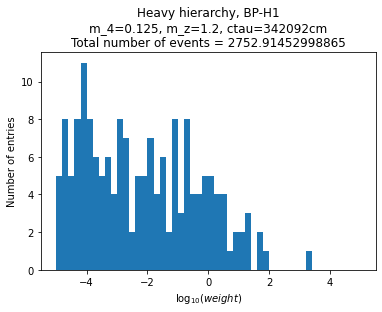

In [101]:
plt.hist(np.log10(weights[weights!=0]), bins=50, range=(-5, 5))
plt.xlabel(r'$\log_{10}(weight)$')
plt.ylabel('Number of entries')
plt.title(f'Heavy hierarchy, BP-H1\nm_4={parameters[0]}, m_z={parameters[1]}, ctau={ctau:.0f}cm\nTotal number of events = {weights.sum()}')

## Advanced plots

In [ ]:
# samples[:,2] = samples[:,2]*Vmu4
# samples[:,3] = samples[:,3]*alpha_epsilon2
# ctau_fit = ctau_light(samples[:, 0], samples[:, 1], samples[:,2])
# aux_sample = np.concatenate([samples, ctau_fit[...,np.newaxis]], axis=1)
# aux_sample_with_logs = aux_sample
# aux_sample_with_logs[:,2] = np.log10(aux_sample_with_logs[:,2])
aux_sample_with_logs[:,3] = np.log10(aux_sample_with_logs[:,3])
aux_sample_with_logs[:,4] = np.log10(aux_sample_with_logs[:,4])

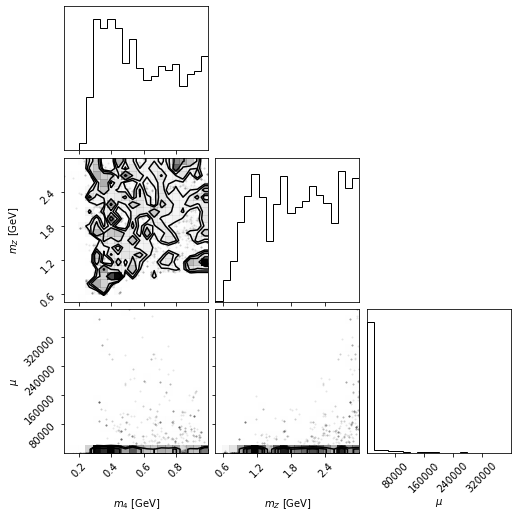

In [69]:
figure = corner.corner(samples, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$\mu$'])

In [ ]:
figure = corner.corner(samples, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$V_{\mu 4}$', r'$\alpha \epsilon^2$'])
# plt.savefig(save_folder + 'out_mcmc_4pars_16walkers.png', dpi=250)

In [ ]:
figure = corner.corner(aux_sample, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$V_{\mu 4}$', r'$\alpha \epsilon^2$', r'c$\tau$'])
# plt.savefig(save_folder + 'contour_light_minimal.png', dpi=250)

In [ ]:
plt.hist(np.log10(ctau_fit), bins=50)
plt.xlabel(r'$\log_{10}(c\tau$) [cm]')
plt.savefig(save_folder + 'ctau.png', dpi=250)

In [ ]:
plt.hist(np.log10(samples[:,2]), bins=50)
plt.xlabel(r'$\log_{10}(V_{\mu 4}$)')
plt.savefig(save_folder + 'Vmu4.png', dpi=250)

In [ ]:
plt.hist(np.log10(samples[:,3]), bins=50)
plt.xlabel(r'$\log_{10}(\alpha_{QED}\epsilon^2$)')
plt.savefig(save_folder + 'alpha_epsilon2.png', dpi=250)

In [ ]:
figure = corner.corner(aux_sample_with_logs, labels=[r'$m_4$ [GeV]', r'$m_Z$ [GeV]', r'$\log_{10}(V_{\mu 4})$', r'$\log_{10}(\alpha \epsilon^2)$', r'$\log_{10}(c\tau$)'])
plt.savefig(save_folder + 'contour_light_minimal_logs.png', dpi=250)